# Example with FORGE Earthquake data

The Python packages we'll use are:

 - pandas, already available in Colab
 - matplotlib.pyplot, already available in Colab
 - obspy, needs to be installed
 - maybe some others** like scipy.fftpack or numpy?*

To run a bash (command-line) command in a Jupyter notebook on Colab, use an ! before the command. Below is the command to install obspy.

In [6]:
# !pip install --upgrade pip
!pip install obspy

     |████████████████████████████████| 1.4MB 2.8MB/s eta 0:00:01
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
  Using cached obspy-1.2.1.zip (24.7 MB)
    ERROR: Command errored out with exit status 1:
     command: /Users/nate/.pyenv/versions/3.7.3/bin/python3.7 -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/9g/z01pkf2n5j13z2xc0kp8rq1r0000gp/T/pip-install-tcn7shfs/obspy/setup.py'"'"'; __file__='"'"'/private/var/folders/9g/z01pkf2n5j13z2xc0kp8rq1r0000gp/T/pip-install-tcn7shfs/obspy/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /private/var/folders/9g/z01pkf2n5j13z2xc0kp8rq1r0000gp/T/pip-install-tcn7shfs/obspy/pip-egg-info
         cwd: /private/var/folders/9g/z01pkf2n5j13z2xc0kp8rq1r0000gp/T/pip-install-tcn7shfs/obspy/
    Complete output (1

In [113]:
%matplotlib notebook
import pandas as pd
import numpy as np
import scipy.fftpack as ft
import matplotlib.pyplot as plt
import obspy

In [2]:
time = obspy.UTCDateTime("2019-04-27T20:20:57.0") # this is a small microseismic event located by SLB

# Download data

### DAS data

In [ ]:
!wget -q https://pando-rgw01.chpc.utah.edu/silixa_das_apr_27_2019/FORGE_78-32_iDASv3-P11_UTC190427202053.sgy
!wget -q https://pando-rgw01.chpc.utah.edu/silixa_das_apr_27_2019/FORGE_78-32_iDASv3-P11_UTC190427202108.sgy

In [69]:
def load_das_data_for_event(eventTime,padBefore,padAfter):
    #
    # import DAS data for a CWD sgy file and set stream metadata for Forge DAS array
    #
    import obspy
    dx=1.02
    wellHeadChannel=205
    wellBottomChannel=1180;
    S = obspy.read('*.sgy',format='segy')
    S.sort()
    for i,tr in enumerate(S):
        tr.stats.station='%05d' % tr.stats.segy['trace_header']['trace_sequence_number_within_line'];
        tr.stats.distance=(tr.stats.segy['trace_header']['trace_sequence_number_within_line']-wellHeadChannel)*dx;
    return  S.merge().trim(starttime=time-padBefore,endtime=time+padAfter)


In [70]:
strainrate_from_das = load_das_data_for_event(time,2,5)

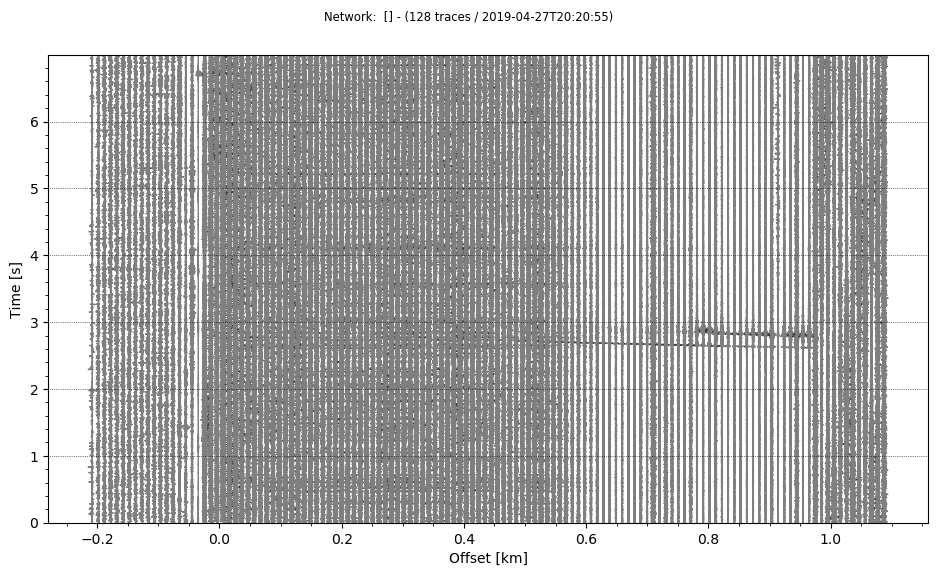

In [93]:
strainrate_from_das[::10].plot(type='section');

### Geophone data

In [16]:
!wget -q https://pando-rgw01.chpc.utah.edu/slb_2019_MW78-32_014/20190427202101.868.segy
!wget -q https://pando-rgw01.chpc.utah.edu/slb_2019_MW78-32_014/20190427202045.868.segy

In [58]:
def load_geophone_data_for_event(eventTime,padBefore,padAfter):
    #
    # import geophone data for a CWD segy file and set stream metadata for Forge geophone array
    #
    import os
    import obspy
    import numpy as np
    n_geophones=12 #these are included in the Forge report, SLB section
    z0 = 645.28
    z1 = 980.56
    geophone_locations = np.linspace(z0,z1,n_geophones)
    dx = geophone_locations[1] - geophone_locations[0] # m
    velocity_from_geophone = obspy.Stream()
    files = [x for x in os.listdir('./') if x.startswith('2019') and x.endswith('segy')]
    nf = len(files)
    S = obspy.Stream()
    for i,f in enumerate(files):
        st = obspy.read(f,format='segy')
        for geophone in range(n_geophones):
            for ich in np.arange(geophone*3,geophone*3+3,1):
                st[ich].stats.network = '78-32'
                st[ich].stats.location = '00'
                st[ich].stats.station = str(geophone)
                st[ich].stats.distance= geophone_locations[geophone];
                if np.mod(ich,3)==0:            # correcting mislabeled header info
                    st[ich].stats.channel = '2'
                if np.mod(ich,3)==1:
                    st[ich].stats.channel = '1'
                if np.mod(ich,3)==2:
                    st[ich].stats.channel = 'Z'
                S+=st[ich]
    return S.merge().trim(starttime=eventTime-padBefore,endtime=eventTime+padAfter)

In [64]:
velocity_from_geophones = load_geophone_data_for_event(time,2,5)

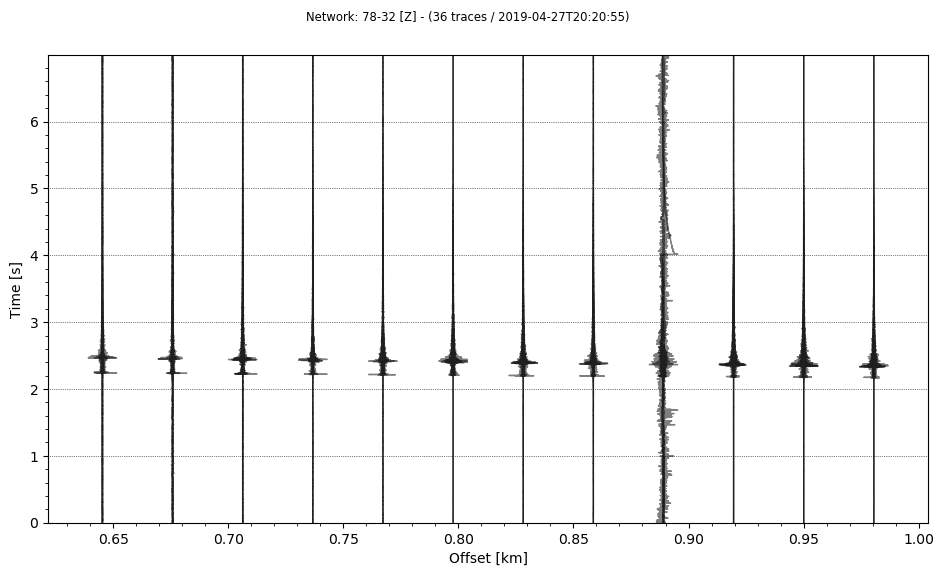

In [91]:
velocity_from_geophones.plot(type='section');

# Geophone-DAS Analysis

Colocated simultaneous recordings made by inertial geophones and DAS can be compared directly after basic processing. 

The processing steps required for this instrument comparison involve spatial or temporal derivatives. Geophones record the particle velocity due to a propagating displacement wavefield, $U(x,t) = Ae^{i(\omega t-kx)}$, which mathematically is equivalent to taking one time-derivative of the displacement:

$$
\frac{dU(x,t)}{dt} = i\omega Ae^{i(\omega t\pm kx)}
$$

The DAS instrument records the strain-rate field, equivalent to taking one space-derivative and one time-derivative of the displacement:

$$
\frac{d\epsilon(x,t)}{dt} = \frac{d}{dt}(\frac{dU(x,t)}{dx}) = -\omega k Ae^{i(\omega t\pm kx)}.
$$

The amplitude and phase of geophone and DAS data can thus be compared in absolute units of strain by multiplying the geophone data by the inverse phase velocity ($\frac{1}{c}$, a multiplicative constant under the acoustic plane wave assumption) and integrating the DAS data:
$$
\epsilon(x,t) = \frac{\omega}{k}\frac{dU(x,t)}{dt} = \frac{1}{c}\frac{dU(x,t)}{dt}.
$$

Alternatively, we can differentiate the geophone data to acceleration and multiply the DAS data by inverse phase velocity:
$$
\frac{d^2U(x,t)}{dt^2} = -\omega^2 Ae^{i(\omega t\pm kx)}
$$
$$
\frac{d\epsilon(x,t)}{dt} = \frac{\omega}{k}\frac{d}{dt}(\frac{d^2U(x,t)}{dt^2}) = \frac{1}{c}\frac{d^2U(x,t)}{dt^2}
$$

If the phase velocity is unknown, any comparison will only result in a relative amplitude scale (but records should be in-phase).

We process the geophone point sensor data by loading the raw velocity data, applying a linear detrend, mean removal, and 2% taper, then differentiating to acceleration data, and finally applying a two-corner, causal bandpass filter in the range 1 - 1000 Hz. 

We process the DAS array data by applying a linear detrend, mean removal, and 2% taper, then removing the zero-wavenumber noise in the frequency-wavenumber domain over the full array of sensors installed in the well, and finally applying a two-corner, causal bandpass filter in the range 1 - 1000 Hz. 



##### Plot raw gathers

In [101]:
def stream2array(stream):
    import numpy as np
    import obspy
    array=np.empty((len(stream),len(stream[0].data)),dtype=float) # initialize array
    for index,trace in enumerate(stream):
        array[index,:]=trace.data
    return array

def stackLinear(stream):
    import numpy as np
    tr = stream[0].copy()
    arr = stream2array(stream)
    arrData = np.sum(arr,0) / len(stream)
    tr.data = arrData
    return tr

In [102]:
def plotGather(stream,padBefore,padAfter,vmin=-1,vmax=1,trnorm=1):
    import matplotlib.pyplot as plt
    distanceVector = [tr.stats.distance for tr in stream]
    fig,ax = plt.subplots(1,1,figsize=(8,8))
    dt = stream[0].stats.delta
    nt = stream[0].stats.npts
    if trnorm==True:
        arr = stream2array(stream.normalize(global_max=False))
    else:
        arr = stream2array(stream.normalize(global_max=True))
    plt.imshow(arr,aspect='auto',
               extent=[-padBefore,padAfter,max(distanceVector),min(distanceVector)],
               cmap='viridis',vmin=vmin,vmax=vmax)
    h=plt.colorbar(pad=0.01)
    h.set_label('Normalized Strain-rate',rotation=270,labelpad=20)
    plt.ylabel('Linear Fiber Length [m]')
    plt.xlabel('Time [s]')
    return fig,ax

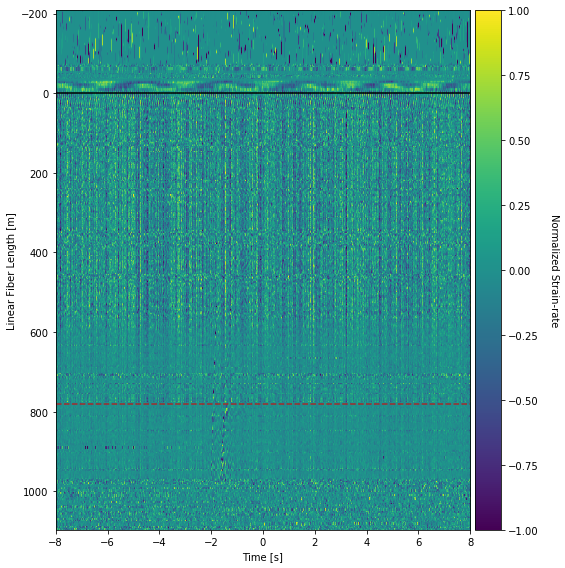

In [112]:
# plot DAS
fig,ax = plotGather(strainrate_from_das,8,8,trnorm=1)
plt.axhline(0,color='k',linestyle='-')
plt.axhline(780,color='brown',linestyle='--')
# plt.xlim([-1.5,-.5])
plt.tight_layout()

##### Plot preprocessed gathers

<IPython.core.display.Javascript object>


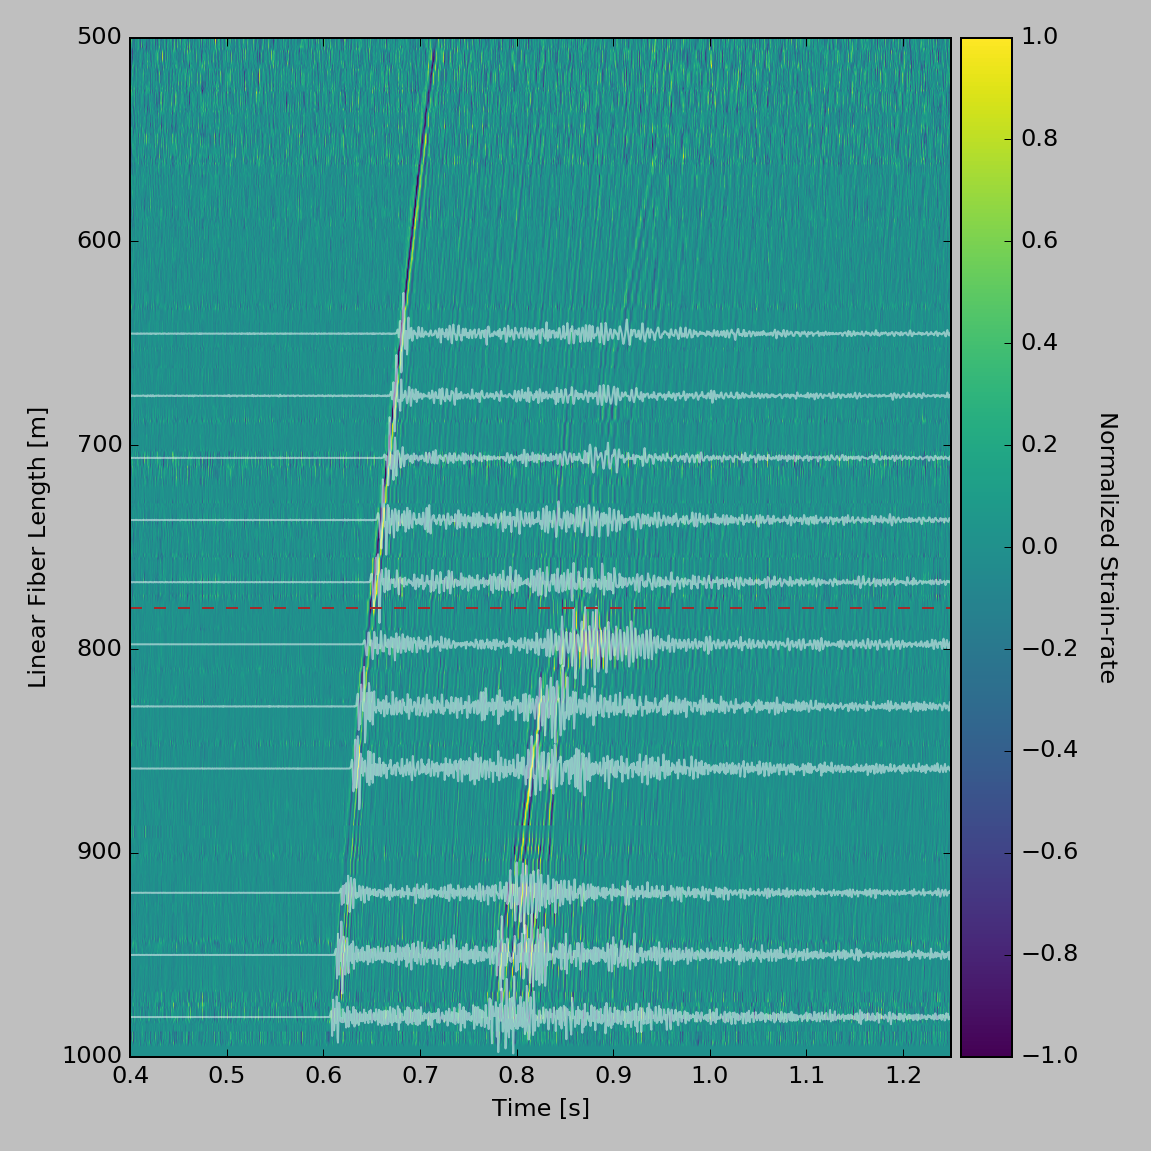

In [16]:
# plot 'D_gather_strainrate_withGvelocity_preprocessing.png
fig,ax = plotGather(das_strainrate_preprocess,padBefore,padAfter,das_distances,trnorm=1,vmin=-1,vmax=1)
sta=[0,1,2,3,4,5,6,7,9,10,11]
cha='Z'
sft = 0.44 # event1
# sft = 1.022 # event2
fig = plotGeophonesAsGather(geophone_acceleration_preprocess,padBefore,stations_to_plot=sta,
                            rescale=20,shift=sft,fig=fig,color='w')
plt.axhline(0,color='k',linestyle='-')
plt.axhline(780,color='brown',linestyle='--')
plt.xlim([0.4,1.25]) # event1
# plt.xlim([-.4,0.6])
plt.ylim([1000,500])
plt.tight_layout()
plt.savefig(figDir+'preprocessing/'+'D_gather_strainrate_withGvelocity.png',dpi=300)

In [17]:
pos = [x for x in [837,866,896,926,956,986,1016,1046,1076,1105,1136,1165]]
pos_plusHalf = [x for x in [852,881,911,941,971,1001,1031,1061,1091,1120,1151]]

In [18]:
def plotAmpSpectra(trace,normTrace=1,fig=fig,color='k',alpha=1,label=''):
    from scipy import signal
    import matplotlib.pyplot as plt
    import numpy as np
    f_psd, psd_trace = signal.welch(trace.data,fs=trace.stats.sampling_rate)
    _,psd_trace_norm = signal.welch(normTrace.data,fs=normTrace.stats.sampling_rate)
    psd_trace_norm_max = np.max(np.max(psd_trace_norm))
    plt.plot(f_psd,10*np.log10((psd_trace/psd_trace_norm_max)**2),color=color,alpha=alpha,label=label)
    return fig

NameError: name 'geophone_acceleration' is not defined

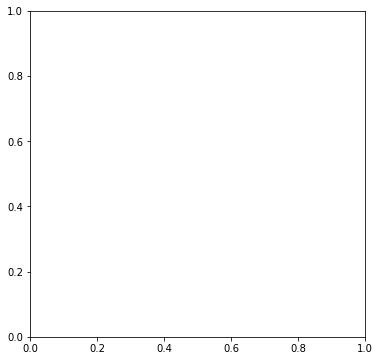

In [96]:

for geophoneIndex in range(1):
    
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    
    #EVENT 1
# #     noise_t0 = 5.3 #P only
# #     noise_t1 = 5.5
# #     signal_t0 = 5.6
# #     signal_t1 = 5.8
    noise_t0 = 3.5 #full Signal
    noise_t1 = 5
    signal_t0 = 5.5
    signal_t1 = 7
    
#     #EVENT 2
#     noise_t0 = 4.3 #S only
#     noise_t1 = 4.5
#     signal_t0 = 5.2
#     signal_t1 = 5.4
#     noise_t0 = 3.5  #full Signal
#     noise_t1 = 4.5 
#     signal_t0 = 4.75 
#     signal_t1 = 5.75 

    tr0 = geophone_acceleration[geophoneIndex].copy().normalize()
    tr0_noise = tr0.copy().trim(starttime=tr0.stats.starttime+noise_t0-sft,endtime=tr0.stats.starttime+noise_t1-sft)
    tr0_signal = tr0.copy().trim(starttime=tr0.stats.starttime+signal_t0-sft,endtime=tr0.stats.starttime+signal_t1-sft)
    fig = plotAmpSpectra(tr0_noise,normTrace=tr0_signal,fig=fig,alpha=0.5,label='Geophone Noise')
    fig = plotAmpSpectra(tr0_signal,normTrace=tr0_signal,fig=fig,label='Geophone Signal')

    # fig,ax = plt.subplots(1,1,figsize=(8,8))
    tr1 = das_strainrate_preprocess[pos_plusHalf[geophoneIndex]].copy().normalize()
    tr1_noise = tr1.copy().trim(starttime=tr1.stats.starttime+noise_t0,endtime=tr1.stats.starttime+noise_t1)
    tr1_signal = tr1.copy().trim(starttime=tr1.stats.starttime+signal_t0,endtime=tr1.stats.starttime+signal_t1)
    fig = plotAmpSpectra(tr1_noise,normTrace=tr1_signal,fig=fig,color='r',alpha=0.5,label='DAS Noise')
    fig = plotAmpSpectra(tr1_signal,normTrace=tr1_signal,fig=fig,color='r',label='DAS Signal')

#     gl=15
#     tr1s = stackLinear(das_strainrate_preprocess[int(pos_plusHalf[geophoneIndex]-gl/2):int(pos_plusHalf[geophoneIndex]+gl/2)].copy().normalize())
#     tr1s_noise = tr1s.copy().trim(starttime=tr1s.stats.starttime+noise_t0,endtime=tr1s.stats.starttime+noise_t1)
#     tr1s_signal = tr1s.copy().trim(starttime=tr1s.stats.starttime+signal_t0,endtime=tr1s.stats.starttime+signal_t1)
#     fig = plotAmpSpectra(tr1s_noise,normTrace=tr1s_signal,fig=fig,color='m',alpha=0.5,label='DAS Noise +/- '+str(gl/2))
#     fig = plotAmpSpectra(tr1s_signal,normTrace=tr1s_signal,fig=fig,color='m',label='DAS Signal +/- '+str(gl/2))

    plt.ylim(-120,30)
    plt.grid(which='both')
    plt.ylabel('Amplitude Power Spectra [dB]')
    plt.xlabel('Frequency [Hz]')
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig(figDir+'snr/psd_'+str(geophoneIndex)+'.png')
    
    
    fig,ax = plt.subplots(1,1,figsize=(10,6))
    highcut = 200
    tr0.filter('lowpass',freq=highcut)
    tr0_noise = tr0.copy().trim(starttime=tr0.stats.starttime+noise_t0-sft,endtime=tr0.stats.starttime+noise_t1-sft)
    tr0_signal = tr0.copy().trim(starttime=tr0.stats.starttime+signal_t0-sft,endtime=tr0.stats.starttime+signal_t1-sft)
    fig = plt.plot(tr0.times()+sft,tr0.data,color='gray',alpha=0.5)
    fig = plt.plot(tr0_noise.times()+noise_t0,tr0_noise.data,color='k',alpha=0.3,label='Geophone Noise')
    fig = plt.plot(tr0_signal.times()+signal_t0,tr0_signal.data,color='k',label='Geophone Signal')

    tr1.filter('lowpass',freq=highcut)
    tr1_noise = tr1.copy().trim(starttime=tr1.stats.starttime+noise_t0,endtime=tr1.stats.starttime+noise_t1)
    tr1_signal = tr1.copy().trim(starttime=tr1.stats.starttime+signal_t0,endtime=tr1.stats.starttime+signal_t1)
    fig = plt.plot(tr1.times(),tr1.data+1,color='gray',alpha=0.5)
    fig = plt.plot(tr1_noise.times()+noise_t0,tr1_noise.data+1,color='r',alpha=0.3,label='DAS Noise')
    fig = plt.plot(tr1_signal.times()+signal_t0,tr1_signal.data+1,color='r',label='DAS Signal')

#     tr1s_ = das_strainrate_preprocess[int(pos_plusHalf[geophoneIndex]-gl/2):int(pos_plusHalf[geophoneIndex]+gl/2)].copy()
#     tr1s_.filter('lowpass',freq=highcut)
#     tr1s = stackLinear(tr1s_.normalize())
#     tr1s.filter('lowpass',freq=highcut)
#     tr1s_noise = tr1s.copy().trim(starttime=tr1s.stats.starttime+noise_t0,endtime=tr1s.stats.starttime+noise_t1)
#     tr1s_signal = tr1s.copy().trim(starttime=tr1s.stats.starttime+signal_t0,endtime=tr1s.stats.starttime+signal_t1)
#     fig = plt.plot(tr1s.times(),tr1s.data+2,color='gray',alpha=0.5)
#     fig = plt.plot(tr1s_noise.times()+noise_t0,tr1s_noise.data+2,color='m',alpha=0.3,label='DAS Noise +/- '+str(gl/2))
#     fig = plt.plot(tr1s_signal.times()+signal_t0,tr1s_signal.data+2,color='m',label='DAS Signal +/- '+str(gl/2))

#     plt.xlim([.2,.5]) # event1
#     plt.xlim([3,7]) # event2, full signal
    plt.xlim([4.,6]) # event2, s-wave only

#     plt.grid(which='both')
    plt.ylabel('')
    plt.xlabel('Time [s]')
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig(figDir+'snr/timeseries_'+str(geophoneIndex)+'.png')

In [ ]:


#
def plotSpectra(stream,distanceVector,figname='0.png'):
    ntr=len(stream)
    f,spec = psd(stream)
    data = (10*np.log10(spec**2))
    data /= np.max(data)
    fig,ax = plt.subplots(1,1,figsize=(8,8))
    plt.imshow(data,aspect='auto',cmap=pqlx,
               extent=[10,max(f),max(distanceVector),min(distanceVector)],)
    plt.xscale('log')
    h = plt.colorbar(pad=0.01)
    h.set_label('Power Spectral Density [10*np.log10($\dot\epsilon^2$/Hz)]',rotation=270,labelpad=20)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Linear Fiber Distance [1 ch/m]')
    return fig,ax

def plotFK(f,k,fk,vmin=-3,vmax=5):
    import numpy as np
    import matplotlib.pyplot as plt
    fig,ax = plt.subplots(figsize=(5,5))
    plt.imshow(np.log10(np.abs(fk)),extent=[min(f),max(f),min(k),max(k)],
               aspect='auto',cmap='jet',vmin=vmin,vmax=vmax)
    h = plt.colorbar()
    h.set_label('Power [strain-rate]')
    plt.xlabel('frequency [1/s]')
    plt.ylabel('wavenumber [1/m]')
    c=3000; ax.plot(f,f/c,color='r'); ax.plot(-f,f/c,color='r')
#     c=45; ax.plot(f,f/c,color='r'); ax.plot(-f,f/c,color='r')
    plt.tight_layout()
    return ax

#
dx = 1.08
ot = 0.
nametag = figDir+'event1_das'
das_norm = False
#
das = strainrate_from_das_pp.copy()
das.normalize(global_max = False)
for i,tr in enumerate(das):
    tr.stats.distance = dx*i
start = das[0].stats.starttime+30.
end = das[0].stats.starttime+31
#
distances2 = [tr.stats.distance for tr in strainrate_from_das]
ntr = len(das)
das.normalize(global_max=False)
nametag = nametag+'_trNorm'



# #
# fig,ax = plotSpectra(das,distances2,)
# plt.tight_layout()
# plt.savefig(nametag+'_psd.png',dpi=300)

# #
# F,K,SPEC = fk(das,dx)
# ax = plotFK(F,K,SPEC,vmin=2,vmax=3.5)
# plt.xlim([-1000,1000])
# plt.ylim([-0.5,0.5])

##### Convert geophone velocity data to strainrate_from_geophone data

In [8]:
#
# Geophones.Z create raw stream for ploting
#
# dU/dt = iwU
# d(dU/dt)/dt = -w^2U
# d(dU/dx)/dt = d(dU/dt)/dx = (dU2/dt - dU1/dt) / (X2-X1) = ik(U2-U1)
#

# half_distances=[d+30.48/2 for d in distances[:-1]]
# intervals = [distances[x+1] - distances[x] for x in range(len(distances)-1)]
# strainrate_from_geophone = velocity_from_geophone.select(channel='Z').copy()[:-1]
# for i,tr in enumerate(strainrate_from_geophone):
#     tr.data = (velocity_from_geophone.select(channel='Z')[i+1].data - velocity_from_geophone.select(channel='Z')[i].data) / intervals[i];
#     tr.stats.distance = half_distances[i];

# #
# fig = plt.figure(figsize=(10,3))
# strainrate_from_geophone[0].plot(fig=fig,show=False);
# velocity_from_geophone.select(channel='Z')[0].plot(fig=fig)

# Preprocess geophone and DAS data

In [389]:


strainrate_from_das_pp = preprocessing_for_das(strainrate_from_das,dx,fmin,fmax)
acc_from_geophone_pp = preprocessing_for_geophones(velocity_from_geophone,fmin,fmax)

In [404]:
fmin=1
fmax=999
dx = 1.08

In [350]:
tr0.data

array([ nan,  nan,  nan, ...,  nan,  nan,  nan])

# Plot Gathers

##### Geophone velocity only

In [464]:
figDir

'../figs/preprocessing/'

/Users/nate/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


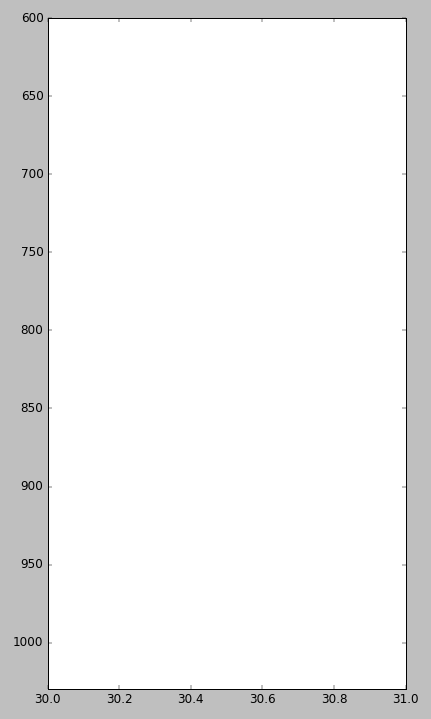

In [465]:
fig,ax = plt.subplots(1,1,figsize=(6,10))

# #
geo_shift=0
fmin=50
fmax=1000
gph_skip  = 1
gph_scale = 40.
gph_color = 'r'
gph_color2 = 'm'
gph_norm  = True
# gph_kill = [8]
gph = velocity_from_geophone_pp.copy()
for i,tr in enumerate(gph):
    if i==0:
        plt.plot(geo_shift+tr.times(),gph_scale*tr.data+(tr.stats.distance),color=gph_color,alpha=1,label='Geophone.2')
    else:
        plt.plot(geo_shift+tr.times(),gph_scale*tr.data+(tr.stats.distance),color=gph_color,alpha=1)
plt.ylim([1030,600])
plt.xlim([30,31])
plt.tight_layout()
plt.savefig(figDir+'geophonesAcc.png')

/Users/nate/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


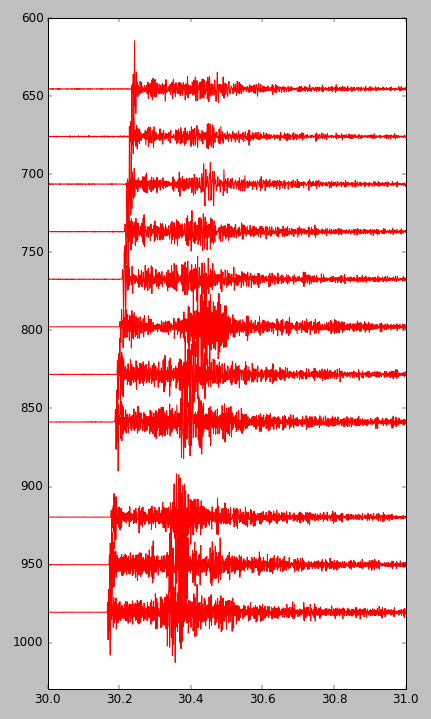

In [463]:
fig,ax = plt.subplots(1,1,figsize=(6,10))

# #
geo_shift=0
fmin=50
fmax=1000
gph_skip  = 1
gph_scale = 40.
gph_color = 'r'
gph_color2 = 'm'
gph_norm  = True
# gph_kill = [8]
gph = acc_from_geophone_pp.copy()
for i,tr in enumerate(gph):
    if i==0:
        plt.plot(geo_shift+tr.times(),gph_scale*tr.data+(tr.stats.distance),color=gph_color,alpha=1,label='Geophone.2')
    else:
        plt.plot(geo_shift+tr.times(),gph_scale*tr.data+(tr.stats.distance),color=gph_color,alpha=1)
plt.ylim([1030,600])
plt.xlim([30,31])
plt.tight_layout()
plt.savefig(figDir+'geophonesAcc.png')

##### Geophone strain-rate only

<IPython.core.display.Javascript object>


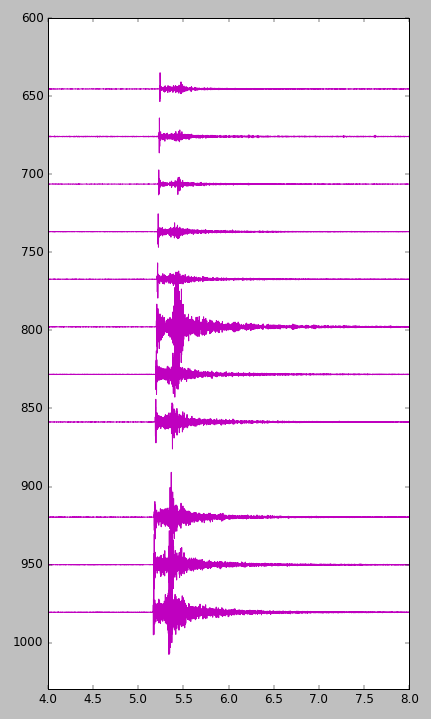

/Users/nate/opt/miniconda3/lib/python3.7/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (1000) of bandpass is at or above Nyquist (1000.0). Applying a high-pass instead.
  warnings.warn(msg)


In [21]:
fig,ax = plt.subplots(1,1,figsize=(6,10))

# #
geo_shift=0
fmin=50
fmax=1000
gph_skip  = 1
gph_scale = 40.
gph_color = 'm'
gph_color2 = 'm'
gph_norm  = True
gph_kill = [8]
gph = G.select(channel='Z').copy()
gph.filter('bandpass',freqmin=fmin,freqmax=fmax,zerophase=False,corners=4)
gph.normalize(global_max=gph_norm)
for tr in gph_kill:
    gph[tr].data*=np.nan
for i,tr in enumerate(gph):
    if i==0:
        plt.plot(geo_shift+tr.times(),gph_scale*tr.data+(tr.stats.distance),color=gph_color,alpha=1,label='Geophone.2')
    else:
        plt.plot(geo_shift+tr.times(),gph_scale*tr.data+(tr.stats.distance),color=gph_color,alpha=1)
plt.ylim([1030,600])
plt.xlim([4,8])
plt.tight_layout()
plt.savefig(figDir+'geophones.png')

In [491]:
strainrate_from_das_pp

1280 Trace(s) in Stream:

Seq. No. in line:    1 | 2019-04-27T20:20:27.000000Z - 2019-04-27T20:21:27.000000Z | 2000.0 Hz, 120001 samples
...
(1278 other traces)
...
Seq. No. in line:    1 | 2019-04-27T20:20:27.000000Z - 2019-04-27T20:21:27.000000Z | 2000.0 Hz, 120001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

/Users/nate/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


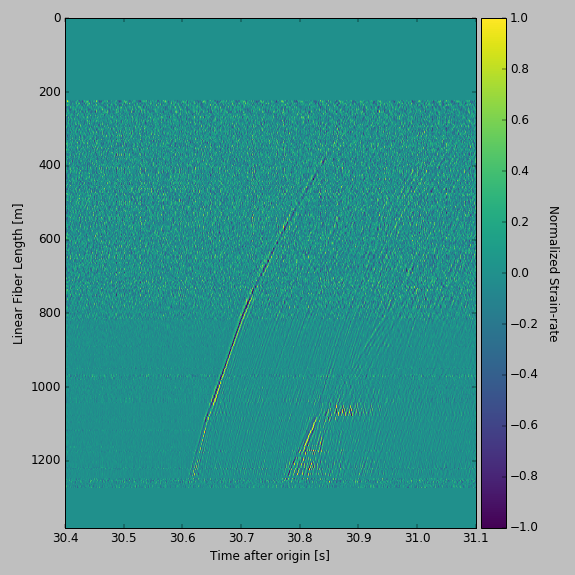

/Users/nate/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/Users/nate/.local/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


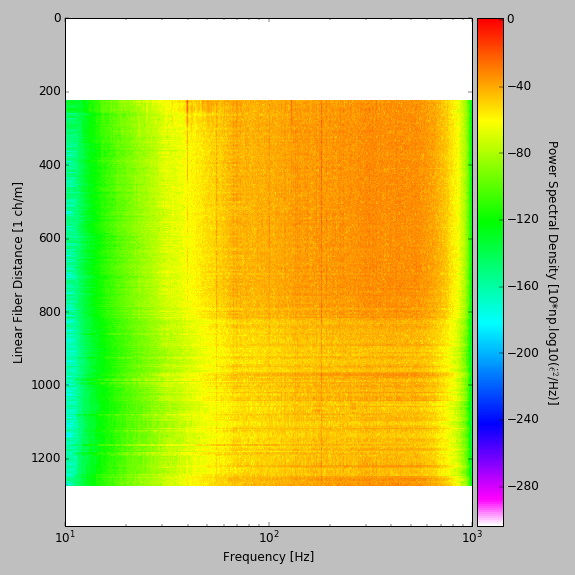

/Users/nate/.local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


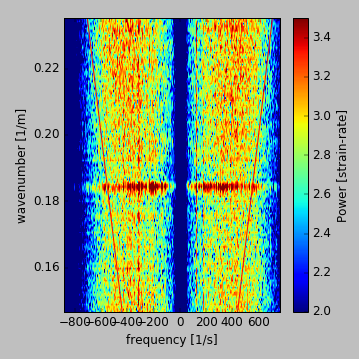

(-0.5, 0.5)